## Setting

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append("/content/drive/My Drive/LCNN/")

import os
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt



import imp
import importlib
import LCNN
imp.reload(LCNN)
from LCNN import adjust,accuracy,one_hot
device = torch.device('cuda')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
batchsize=64

trainset = datasets.MNIST('/content/drive/My Drive/data', download=True, train=True, transform=transform)
valset = datasets.MNIST('/content/drive/My Drive/data', download=True, train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
batchsize=64

trainset = datasets.FashionMNIST('/content/drive/My Drive/data', download=True, train=True, transform=transform)
valset = datasets.FashionMNIST('/content/drive/My Drive/data', download=True, train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)

# 2 layers

## Full batch

In [6]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

num_classes = 10
batch_size = 64


class NeuralNet2layer(nn.Module):
    def __init__(self, input_size, hidden_size1,num_classes, initialize='NTK',batchnorm=False):
        super(NeuralNet2layer, self).__init__()
        self.initialize=initialize
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.batchnorm = batchnorm


        self.fc1 = nn.Linear(input_size, hidden_size1) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias=False)


        if self.batchnorm:
            self.bn1 = nn.BatchNorm1d(num_features=hidden_size1)
        
        if self.initialize=='NTK':

            self.fc1.weight.detach().uniform_(-1, 1)
            self.fc1.bias.detach().uniform_(-1, 1)
            self.fc2.weight.detach().uniform_(-1,1)




    def forward(self, x):
        if self.batchnorm:
            if self.initialize=='LeCun':
                out = self.fc1(x)
                out = self.bn1(out)
                out = self.relu1(out)
                out = self.fc2(out)

            if self.initialize=='NTK':
                out = self.fc1(x)
                out = out/np.sqrt(self.input_size)
                out = self.bn1(out)
                out = self.relu1(out)
                out = self.fc2(out)
                out = out/np.sqrt(self.hidden_size1)
        else:

            if self.initialize=='LeCun':
                out = self.fc1(x)
                out = self.relu1(out)
                out = self.fc2(out)

            if self.initialize=='NTK':
                out = self.fc1(x)
                out = out/np.sqrt(self.input_size)
                out = self.relu1(out)
                out = self.fc2(out)
                out = out/np.sqrt(self.hidden_size1)
        return out
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


In [ ]:
output=[]
for prob in [0,1,2]:
    learning_rate = 0.1
    torch.manual_seed(0)
    batchnorm=False
    if prob==1 or prob==2:
        batchnorm=True
    device = torch.device('cuda')
    model = NeuralNet2layer(input_size, hidden_size1,num_classes, initialize='NTK',batchnorm=batchnorm).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
    criterion = nn.MSELoss()

    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels,num_classes).to(device)



    losslist=[]
    aclist=[]

    
    for runsteps in range(1000*20):
        if (prob==0 or prob==2) and runsteps==0:
            adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.1,ln=1,oflag=1,mode=1)
        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lo=loss.item()


        losslist.append(lo)
        if runsteps%10==0:
            print(prob,runsteps,lo)
            ac=accuracy(model,valloader)
            aclist.append(ac)
        if lo<0.01:
            break
    output.append([losslist,aclist])

Adjusting Layer 1, Kernel Nodes: 682, Adptive Nodes118
0 0 0.16779622435569763
Accuracy: 9.0800 %
0 10 0.08958170562982559
Accuracy: 28.6300 %
0 20 0.06544964760541916
Accuracy: 44.0500 %
0 30 0.05291002616286278
Accuracy: 51.3400 %
0 40 0.04237489774823189
Accuracy: 58.5000 %
0 50 0.03619752079248428
Accuracy: 59.5200 %
0 60 0.03211359679698944
Accuracy: 61.0500 %
0 70 0.02893291786313057
Accuracy: 62.3900 %
0 80 0.02637541852891445
Accuracy: 62.5800 %
0 90 0.024244992062449455
Accuracy: 63.2400 %
0 100 0.022416694089770317
Accuracy: 63.8700 %
0 110 0.020824098959565163
Accuracy: 64.0600 %
0 120 0.019418438896536827
Accuracy: 64.1300 %
0 130 0.018166694790124893
Accuracy: 64.1700 %
0 140 0.017042050138115883
Accuracy: 64.3800 %
0 150 0.016026100143790245
Accuracy: 64.4000 %
0 160 0.015103173442184925
Accuracy: 64.5700 %
0 170 0.014259244315326214
Accuracy: 64.5700 %
0 180 0.013487673364579678
Accuracy: 64.5400 %
0 190 0.012777941301465034
Accuracy: 64.5200 %
0 200 0.01212288998067379


##  New model

In [ ]:
output1=output

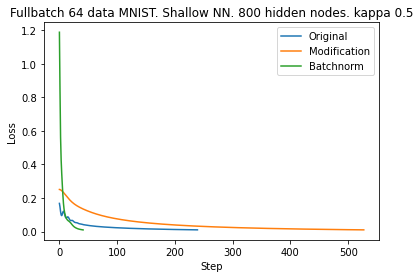

In [ ]:
#plt.plot(output[3][0],'-',label='Original')
plt.plot(output[0][0],'-',label='Modification')
plt.plot(output[1][0],'-',label='Batchnorm')
plt.plot(output[2][0],'-',label='Modification+Batchnorm')

plt.legend()
plt.ylabel('Loss')
plt.xlabel('Step')
#plt.xlim([0,100])

plt.title('Fullbatch 64 data MNIST. Shallow NN. 800 hidden nodes. kappa 0.5')
plt.savefig('/content/drive/My Drive/LCNN/plot/BN1.pdf')

In [ ]:
output=[]
for p in [0,1,2,3]:
    learning_rate = 0.005
    torch.manual_seed(0)
    batchnorm=False
    if p==0:
        batchnorm=True
    device = torch.device('cuda')
    model = NeuralNet2layer(input_size, hidden_size1,num_classes, initialize='LeCun',batchnorm=batchnorm).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
    criterion = nn.MSELoss()

    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels,num_classes).to(device)



    losslist=[]
    aclist=[]

    
    for runsteps in range(1000*20):
        if  runsteps==0:
            if p==1:
                adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.01,ln=1,oflag=1,mode=2)
            if p==2:
                adjust(model,images,threshold_u=10,threshold_l=1,scale=0.01,ln=1,oflag=1,mode=2)
            if p==3:
                adjust(model,images,threshold_u=1,threshold_l=0.1,scale=0.01,ln=1,oflag=1,mode=2)
        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lo=loss.item()


        losslist.append(lo)
        if runsteps%10==0 or runsteps<10:
            print(p,runsteps,lo)
            ac=accuracy(model,valloader)
            aclist.append(ac)
        if lo<0.01:
            break
    output.append([losslist,aclist])

0 0 0.2192450612783432
Accuracy: 14.2500 %
0 1 0.2046246975660324
Accuracy: 15.6700 %
0 2 0.18125595152378082
Accuracy: 18.3100 %
0 3 0.1561608761548996
Accuracy: 21.4100 %
0 4 0.13448825478553772
Accuracy: 24.6800 %
0 5 0.11805691570043564
Accuracy: 27.6200 %
0 6 0.10568659752607346
Accuracy: 30.7300 %
0 7 0.09482963383197784
Accuracy: 33.8500 %
0 8 0.08347003906965256
Accuracy: 37.2800 %
0 9 0.07116067409515381
Accuracy: 40.7700 %
0 10 0.05895313248038292
Accuracy: 44.0800 %
0 20 0.01811934821307659
Accuracy: 54.4000 %
Adjusting Layer 1, Kernel Nodes: 766, Adptive Nodes34
1 0 0.13020654022693634
Accuracy: 9.5800 %
1 1 1.6438095569610596
Accuracy: 8.9200 %
1 2 48.71800994873047
Accuracy: 9.5800 %
1 3 1394.90625
Accuracy: 8.9200 %
1 4 1388.6278076171875
Accuracy: 8.9300 %
1 5 1.2078421115875244
Accuracy: 12.3300 %
1 6 0.12407667934894562
Accuracy: 18.5300 %
1 7 0.10582493990659714
Accuracy: 17.6500 %
1 8 0.1308141052722931
Accuracy: 15.4900 %
1 9 0.15081608295440674
Accuracy: 14.1500 %

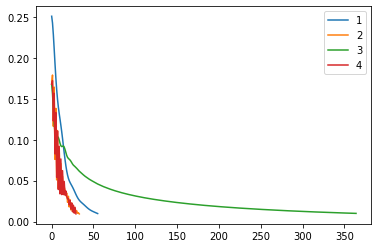

In [ ]:
plt.plot(output[0][0],label='1')
plt.plot(output[1][0],label='2')
plt.plot(output[2][0],label='3')
plt.plot(output[3][0],label='4')
plt.legend()

In [ ]:
a=model.state_dict()['fc'+str(ln)+'.bias'][i]

In [ ]:
 ab=torch.cat((a,b.reshape(-1)),dim=0)

RuntimeError: ignored